In [16]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd


In [17]:

# Set random seed for reproducibility
torch.manual_seed(42)

# Check if GPU is available
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
print(f"GPU device: {device_gpu}")
print(f"CPU device: {device_cpu}")


GPU device: cuda:0
CPU device: cpu


In [18]:

# Check if BFloat16 is supported on CPU (compatible with different PyTorch versions)
try:
    # Try newer PyTorch versions
    if hasattr(torch.cpu, 'is_bf16_supported'):
        bf16_supported = torch.cpu.is_bf16_supported()
    # Try alternate method for older versions
    elif hasattr(torch, 'is_bf16_supported'):
        bf16_supported = torch.is_bf16_supported()
    else:
        # Fall back to checking if we can create a bf16 tensor
        try:
            test_tensor = torch.zeros(1, dtype=torch.bfloat16)
            bf16_supported = True
        except:
            bf16_supported = False
except:
    bf16_supported = False

print(f"BFloat16 supported on CPU: {bf16_supported}")

BFloat16 supported on CPU: True


In [19]:

# Define a simple CNN model using reshape instead of view
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        # Changed to use Flatten instead of manually reshaping
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        # Use flatten instead of view to handle any memory layout
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to get CIFAR-10 dataset
def get_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )

    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )

    return train_dataset, test_dataset

# Function to create data loaders with various configurations
def create_dataloaders(train_dataset, test_dataset, batch_size, num_workers):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return train_loader, test_loader


In [20]:

# Function to train the model on GPU
def train_model_gpu(model, train_loader, criterion, optimizer, num_epochs=1):
    model.train()
    model = model.to(device_gpu)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device_gpu), labels.to(device_gpu)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"GPU Training - Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

    return model

# Function to evaluate model accuracy
def evaluate_model(model, test_loader, device):
    model.eval()
    model = model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on {device}: {accuracy:.2f}%")
    return accuracy

# Function to benchmark model performance (FPS)
def benchmark_fps(model, test_loader, device, use_channels_last=False, use_amp=False):
    model.eval()
    model = model.to(device)

    # Apply channels_last memory format if specified
    if use_channels_last and device == torch.device("cpu"):
        model = model.to(memory_format=torch.channels_last)

    total_samples = 0
    start_time = time.time()

    with torch.no_grad():
        for data in tqdm(test_loader):
            images, _ = data
            images = images.to(device)

            # Apply channels_last to input if specified
            if use_channels_last and device == torch.device("cpu"):
                images = images.to(memory_format=torch.channels_last)

            # Use AMP if specified
            if use_amp and device == torch.device("cpu") and bf16_supported:
                if hasattr(torch.amp, 'autocast'):
                    with torch.amp.autocast(device_type='cpu', dtype=torch.bfloat16):
                        _ = model(images)
                else:
                    # Fallback for older PyTorch versions without device_type parameter
                    _ = model(images.to(torch.bfloat16))
            else:
                _ = model(images)

            total_samples += images.size(0)

    end_time = time.time()
    elapsed_time = end_time - start_time
    fps = total_samples / elapsed_time

    settings = f"{'Channels Last' if use_channels_last else 'Channels First'}"
    settings += f", {'BF16 AMP' if use_amp else 'FP32'}"

    print(f"Performance on {device} ({settings}): {fps:.2f} samples/sec")
    return fps


In [21]:

# Function to monitor CPU/GPU utilization during inference
def measure_resource_utilization(model, test_loader, device, num_runs=3):
    model.eval()
    model = model.to(device)

    total_time = 0.0
    total_memory = 0.0

    for _ in range(num_runs):
        # Record peak memory before run
        if device == torch.device("cuda:0"):
            torch.cuda.reset_peak_memory_stats()
            try:
                memory_before = torch.cuda.max_memory_allocated() / (1024 ** 2)  # MB
            except:
                memory_before = 0

        start = time.time()

        with torch.no_grad():
            for data in test_loader:
                images, _ = data
                images = images.to(device)
                _ = model(images)

        end = time.time()
        total_time += end - start

        # Record peak memory after run
        if device == torch.device("cuda:0"):
            try:
                memory_after = torch.cuda.max_memory_allocated() / (1024 ** 2)  # MB
                total_memory += memory_after - memory_before
            except:
                total_memory = 0

    avg_time = total_time / num_runs
    avg_memory = total_memory / num_runs if device == torch.device("cuda:0") else "N/A"

    print(f"Avg. inference time on {device}: {avg_time:.4f} sec")
    if device == torch.device("cuda:0"):
        print(f"Avg. peak memory used on GPU: {avg_memory:.2f} MB")

    return avg_time, avg_memory


In [22]:
# Function to test if torch.compile is available
def is_torch_compile_available():
    if not hasattr(torch, "compile"):
        return False
    try:
        # Test with a tiny model to see if it works
        tiny_model = nn.Linear(10, 10)
        compiled_tiny = torch.compile(tiny_model, backend="inductor")
        return True
    except Exception as e:
        print(f"torch.compile not working: {e}")
        return False

# Create model
model = SimpleCNN()

# Get dataset
train_dataset, test_dataset = get_dataset()

# Define batch sizes to test - use smaller set for demo
batch_sizes = [32, 64]

# Define number of workers to test - use smaller set for demo
num_workers_list = [0, 1]

# Initialize results collection
results = []

# Test different combinations of batch size and workers
for batch_size in batch_sizes:
    for num_workers in num_workers_list:
        print(f"\n=== Testing with batch_size={batch_size}, num_workers={num_workers} ===")

        # Create data loaders
        train_loader, test_loader = create_dataloaders(
            train_dataset, test_dataset, batch_size, num_workers
        )

        # Train model on GPU (if available)
        if device_gpu.type == "cuda":
            print("Training on GPU...")
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            try:
                model = train_model_gpu(model, train_loader, criterion, optimizer)
            except Exception as e:
                print(f"Error during GPU training: {e}")
                # Reinitialize model if training fails
                model = SimpleCNN()
        else:
            print("GPU not available, using CPU-initialized model")

        # 1. Benchmark GPU (original model)
        if device_gpu.type == "cuda":
            try:
                gpu_accuracy = evaluate_model(model, test_loader, device_gpu)
                gpu_fps = benchmark_fps(model, test_loader, device_gpu)
                gpu_time, gpu_memory = measure_resource_utilization(model, test_loader, device_gpu)
            except Exception as e:
                print(f"Error during GPU benchmarking: {e}")
                gpu_accuracy = gpu_fps = gpu_time = gpu_memory = "Error"
        else:
            gpu_accuracy = gpu_fps = gpu_time = gpu_memory = "N/A"

        # 2. Benchmark CPU (baseline, no optimization)
        try:
            cpu_accuracy = evaluate_model(model, test_loader, device_cpu)
            cpu_fps_baseline = benchmark_fps(model, test_loader, device_cpu)
            cpu_time_baseline, _ = measure_resource_utilization(model, test_loader, device_cpu)
        except Exception as e:
            print(f"Error during CPU baseline benchmarking: {e}")
            cpu_accuracy = cpu_fps_baseline = cpu_time_baseline = "Error"

        # 3. Benchmark CPU with channels_last memory format
        try:
            cpu_fps_channels_last = benchmark_fps(model, test_loader, device_cpu, use_channels_last=True)
        except Exception as e:
            print(f"Error with channels_last: {e}")
            cpu_fps_channels_last = "Error"

        # 4. Benchmark CPU with AMP (bfloat16)
        if bf16_supported:
            try:
                cpu_fps_amp = benchmark_fps(model, test_loader, device_cpu, use_amp=True)
            except Exception as e:
                print(f"Error with AMP: {e}")
                cpu_fps_amp = "Error"

            try:
                cpu_fps_amp_channels_last = benchmark_fps(model, test_loader, device_cpu, use_channels_last=True, use_amp=True)
            except Exception as e:
                print(f"Error with AMP + channels_last: {e}")
                cpu_fps_amp_channels_last = "Error"
        else:
            cpu_fps_amp = cpu_fps_amp_channels_last = "Not supported"

        # Try with torch.compile if torch version supports it
        torch_compile_available = is_torch_compile_available()
        if torch_compile_available:
            print("\nTesting with torch.compile...")
            try:
                compiled_model = torch.compile(model, backend="inductor")
                compiled_model = compiled_model.to(device_cpu)

                # Warmup
                with torch.no_grad():
                    for data in [next(iter(test_loader))]:
                        images, _ = data
                        images = images.to(device_cpu)
                        _ = compiled_model(images)

                # Benchmark compiled model
                cpu_fps_compiled = benchmark_fps(compiled_model, test_loader, device_cpu)
            except Exception as e:
                print(f"Error with torch.compile: {e}")
                cpu_fps_compiled = "Error"
        else:
            cpu_fps_compiled = "Not available"

        # Save results
        result = {
            "Batch Size": batch_size,
            "Num Workers": num_workers,
            "GPU Accuracy": gpu_accuracy,
            "GPU FPS": gpu_fps,
            "GPU Time (s)": gpu_time,
            "GPU Memory (MB)": gpu_memory,
            "CPU Accuracy": cpu_accuracy,
            "CPU FPS (Baseline)": cpu_fps_baseline,
            "CPU Time (s)": cpu_time_baseline,
            "CPU FPS (Channels Last)": cpu_fps_channels_last,
            "CPU FPS (AMP)": cpu_fps_amp,
            "CPU FPS (AMP + Channels Last)": cpu_fps_amp_channels_last,
            "CPU FPS (Compiled)": cpu_fps_compiled
        }

        results.append(result)



=== Testing with batch_size=32, num_workers=0 ===
Training on GPU...
GPU Training - Epoch 1, Loss: 1.4686
Accuracy on cuda:0: 57.99%


100%|██████████| 313/313 [00:02<00:00, 114.97it/s]


Performance on cuda:0 (Channels First, FP32): 3668.16 samples/sec
Avg. inference time on cuda:0: 3.3751 sec
Avg. peak memory used on GPU: 4.25 MB
Accuracy on cpu: 57.99%


100%|██████████| 313/313 [00:05<00:00, 61.10it/s]


Performance on cpu (Channels First, FP32): 1950.93 samples/sec
Avg. inference time on cpu: 5.2892 sec


100%|██████████| 313/313 [00:04<00:00, 63.57it/s]


Performance on cpu (Channels Last, FP32): 2029.79 samples/sec


100%|██████████| 313/313 [00:04<00:00, 65.03it/s]


Performance on cpu (Channels First, BF16 AMP): 2075.80 samples/sec


100%|██████████| 313/313 [00:05<00:00, 62.34it/s]


Performance on cpu (Channels Last, BF16 AMP): 1989.40 samples/sec

Testing with torch.compile...


100%|██████████| 313/313 [00:13<00:00, 22.41it/s]

Performance on cpu (Channels First, FP32): 715.85 samples/sec

=== Testing with batch_size=32, num_workers=1 ===
Training on GPU...


GPU Training - Epoch 1, Loss: 1.0468
Accuracy on cuda:0: 64.19%


100%|██████████| 313/313 [00:04<00:00, 74.01it/s]

Performance on cuda:0 (Channels First, FP32): 2362.77 samples/sec


Avg. inference time on cuda:0: 3.7241 sec
Avg. peak memory used on GPU: 4.25 MB
Accuracy on cpu: 64.19%


100%|██████████| 313/313 [00:04<00:00, 72.04it/s]

Performance on cpu (Channels First, FP32): 2300.03 samples/sec


Avg. inference time on cpu: 4.7605 sec


100%|██████████| 313/313 [00:05<00:00, 59.24it/s]


Performance on cpu (Channels Last, FP32): 1890.75 samples/sec


100%|██████████| 313/313 [00:04<00:00, 64.73it/s]


Performance on cpu (Channels First, BF16 AMP): 2066.03 samples/sec


100%|██████████| 313/313 [00:05<00:00, 52.90it/s]

Performance on cpu (Channels Last, BF16 AMP): 1688.87 samples/sec

Testing with torch.compile...



100%|██████████| 313/313 [00:04<00:00, 72.63it/s]


Performance on cpu (Channels First, FP32): 2318.57 samples/sec

=== Testing with batch_size=64, num_workers=0 ===
Training on GPU...
GPU Training - Epoch 1, Loss: 0.7969
Accuracy on cuda:0: 69.33%


100%|██████████| 157/157 [00:03<00:00, 51.41it/s]


Performance on cuda:0 (Channels First, FP32): 3268.85 samples/sec
Avg. inference time on cuda:0: 2.5560 sec
Avg. peak memory used on GPU: 8.62 MB
Accuracy on cpu: 69.33%


100%|██████████| 157/157 [00:03<00:00, 42.63it/s]


Performance on cpu (Channels First, FP32): 2713.34 samples/sec
Avg. inference time on cpu: 3.9011 sec


100%|██████████| 157/157 [00:03<00:00, 43.16it/s]


Performance on cpu (Channels Last, FP32): 2746.93 samples/sec


100%|██████████| 157/157 [00:05<00:00, 29.54it/s]


Performance on cpu (Channels First, BF16 AMP): 1879.93 samples/sec


100%|██████████| 157/157 [00:04<00:00, 33.33it/s]


Performance on cpu (Channels Last, BF16 AMP): 2120.97 samples/sec

Testing with torch.compile...


100%|██████████| 157/157 [00:03<00:00, 46.97it/s]

Performance on cpu (Channels First, FP32): 2988.83 samples/sec

=== Testing with batch_size=64, num_workers=1 ===
Training on GPU...


GPU Training - Epoch 1, Loss: 0.6876
Accuracy on cuda:0: 69.57%


100%|██████████| 157/157 [00:03<00:00, 50.56it/s]

Performance on cuda:0 (Channels First, FP32): 3216.49 samples/sec


Avg. inference time on cuda:0: 3.2415 sec
Avg. peak memory used on GPU: 8.62 MB
Accuracy on cpu: 69.57%


100%|██████████| 157/157 [00:04<00:00, 31.67it/s]

Performance on cpu (Channels First, FP32): 2016.28 samples/sec


Avg. inference time on cpu: 4.1735 sec


100%|██████████| 157/157 [00:03<00:00, 39.55it/s]


Performance on cpu (Channels Last, FP32): 2516.97 samples/sec


100%|██████████| 157/157 [00:04<00:00, 36.56it/s]


Performance on cpu (Channels First, BF16 AMP): 2326.54 samples/sec


100%|██████████| 157/157 [00:05<00:00, 29.07it/s]

Performance on cpu (Channels Last, BF16 AMP): 1850.20 samples/sec

Testing with torch.compile...



100%|██████████| 157/157 [00:03<00:00, 41.30it/s]

Performance on cpu (Channels First, FP32): 2628.46 samples/sec


In [26]:

# Create DataFrame with results
df_results = pd.DataFrame(results)
print("\nResults Summary:")
print(df_results)

# Save results to CSV
df_results.to_csv("model_conversion_results.csv", index=False)

# Helper function to safely convert values for plotting
def safe_convert_to_float(value):
    if isinstance(value, (int, float)):
        return value
    return None





Results Summary:
   Batch Size  Num Workers  GPU Accuracy      GPU FPS  GPU Time (s)  \
0          32            0         57.99  3668.162890      3.375131   
1          32            1         64.19  2362.769197      3.724088   
2          64            0         69.33  3268.845214      2.556045   
3          64            1         69.57  3216.485371      3.241512   

   GPU Memory (MB)  CPU Accuracy  CPU FPS (Baseline)  CPU Time (s)  \
0            4.250         57.99         1950.933350      5.289170   
1            4.250         64.19         2300.025647      4.760463   
2            8.625         69.33         2713.341557      3.901099   
3            8.625         69.57         2016.283894      4.173547   

   CPU FPS (Channels Last)  CPU FPS (AMP)  CPU FPS (AMP + Channels Last)  \
0              2029.793505    2075.796928                    1989.399083   
1              1890.747253    2066.026078                    1688.871122   
2              2746.931506    1879.926831      

Improved visualizations created!


<Figure size 1400x800 with 0 Axes>

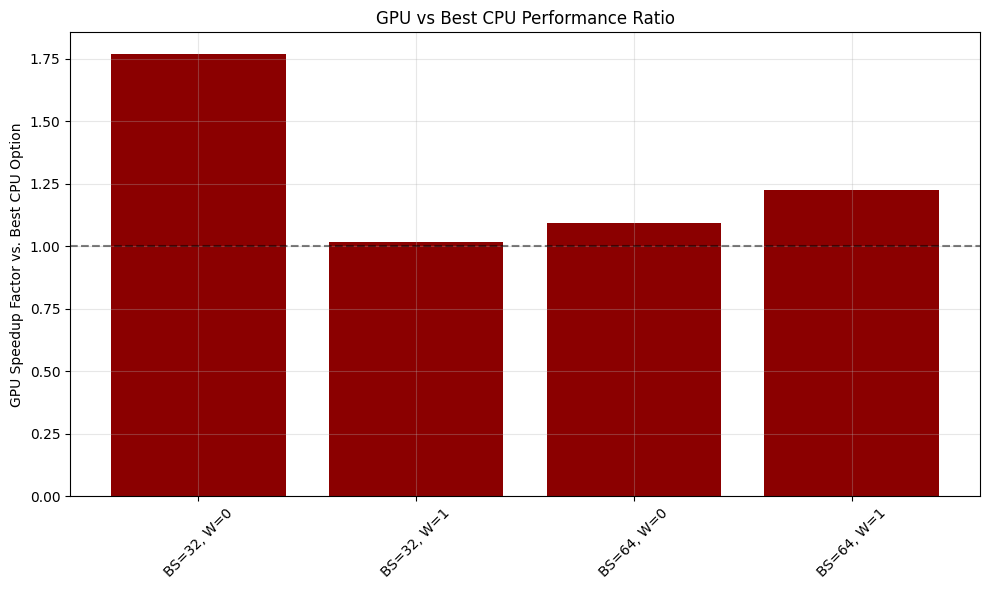

In [25]:
# Improved visualization code for GPU vs CPU comparison
plt.figure(figsize=(14, 8))
x = range(len(results))

# Create separate plots for GPU and CPU to handle different scales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot configurations on x-axis
config_labels = [f"BS={r['Batch Size']}, W={r['Num Workers']}" for r in results]

# GPU plot (left side)
if device_gpu.type == "cuda":
    gpu_fps_values = [safe_convert_to_float(r["GPU FPS"]) for r in results]
    if any(fps is not None for fps in gpu_fps_values):
        ax1.bar(x, gpu_fps_values, width=0.8, color='crimson')
        ax1.set_title("GPU Performance (FPS)")
        ax1.set_xticks(x)
        ax1.set_xticklabels(config_labels, rotation=45)
        ax1.set_ylabel("Frames Per Second")
        ax1.grid(True, alpha=0.3)

# CPU plot with optimizations (right side)
cpu_techniques = [
    ("Baseline", "CPU FPS (Baseline)", "royalblue"),
    ("Channels Last", "CPU FPS (Channels Last)", "lightseagreen"),
    ("AMP", "CPU FPS (AMP)", "darkviolet"),
    ("AMP + Channels Last", "CPU FPS (AMP + Channels Last)", "orange"),
    ("Compiled", "CPU FPS (Compiled)", "forestgreen")
]

width = 0.15  # width of bars
offsets = np.linspace(-0.3, 0.3, len(cpu_techniques))

for i, (label, key, color) in enumerate(cpu_techniques):
    values = [safe_convert_to_float(r[key]) for r in results]
    if any(v is not None for v in values):
        ax2.bar([pos + offsets[i] for pos in x], values, width=width, label=label, color=color)

ax2.set_title("CPU Optimizations Performance (FPS)")
ax2.set_xticks(x)
ax2.set_xticklabels(config_labels, rotation=45)
ax2.set_ylabel("Frames Per Second")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("improved_performance_comparison.png", dpi=300)
plt.close()

# Additional visualization: Normalized comparison (GPU vs best CPU option)
plt.figure(figsize=(10, 6))
gpu_fps = [safe_convert_to_float(r["GPU FPS"]) for r in results]

# Find best CPU performance for each configuration
best_cpu_fps = []
for r in results:
    cpu_values = [
        safe_convert_to_float(r["CPU FPS (Baseline)"]),
        safe_convert_to_float(r["CPU FPS (Channels Last)"]),
        safe_convert_to_float(r["CPU FPS (AMP)"]),
        safe_convert_to_float(r["CPU FPS (AMP + Channels Last)"]),
        safe_convert_to_float(r["CPU FPS (Compiled)"])
    ]
    cpu_values = [v for v in cpu_values if v is not None]
    best_cpu_fps.append(max(cpu_values) if cpu_values else None)

# Calculate speedup of GPU over best CPU option
speedups = []
for i in range(len(results)):
    if gpu_fps[i] is not None and best_cpu_fps[i] is not None and best_cpu_fps[i] > 0:
        speedups.append((gpu_fps[i] / best_cpu_fps[i], config_labels[i]))

if speedups:
    speedup_values = [s[0] for s in speedups]
    speedup_labels = [s[1] for s in speedups]

    plt.bar(range(len(speedups)), speedup_values, color='darkred')
    plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5)
    plt.xticks(range(len(speedups)), speedup_labels, rotation=45)
    plt.ylabel("GPU Speedup Factor vs. Best CPU Option")
    plt.title("GPU vs Best CPU Performance Ratio")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("gpu_cpu_speedup_ratio.png", dpi=300)

print("Improved visualizations created!")


Analysis complete! Results saved to CSV and visualizations saved as PNGs.


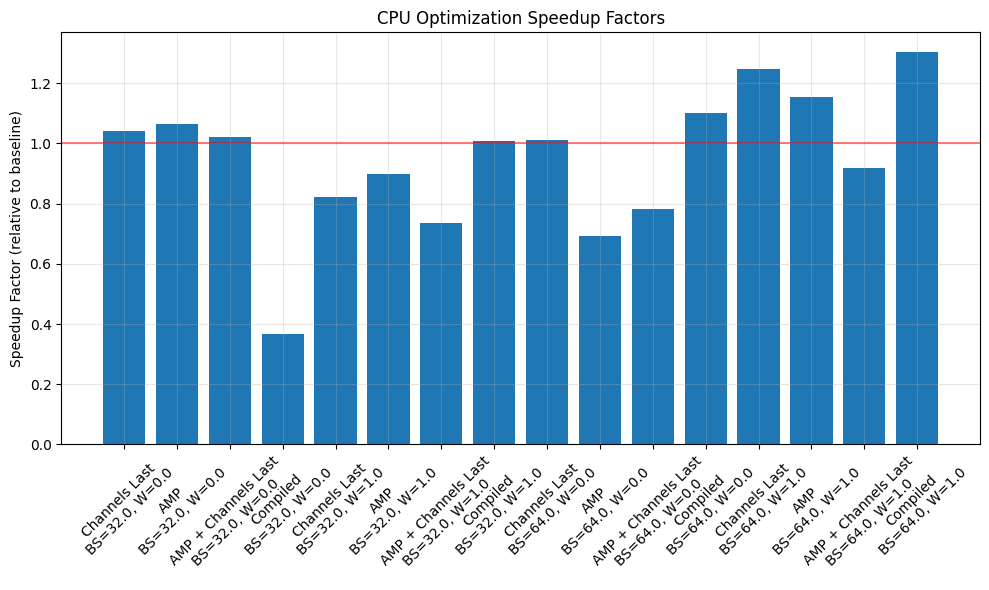

In [24]:
# Plot GPU performance if available
if device_gpu.type == "cuda":
    gpu_fps_values = [safe_convert_to_float(r["GPU FPS"]) for r in results]
    if any(fps is not None for fps in gpu_fps_values):
        plt.bar(x, gpu_fps_values, width=0.1, label="GPU")

# Plot CPU performance with different optimizations
cpu_baseline_values = [safe_convert_to_float(r["CPU FPS (Baseline)"]) for r in results]
if any(fps is not None for fps in cpu_baseline_values):
    plt.bar([i + 0.1 for i in x], cpu_baseline_values, width=0.1, label="CPU (Baseline)")

# Plot CPU with Channels Last if available
cpu_channels_last_values = [safe_convert_to_float(r["CPU FPS (Channels Last)"]) for r in results]
if any(fps is not None for fps in cpu_channels_last_values):
    plt.bar([i + 0.2 for i in x], cpu_channels_last_values, width=0.1, label="CPU (Channels Last)")

# Plot CPU with AMP if supported and available
cpu_amp_values = [safe_convert_to_float(r["CPU FPS (AMP)"]) for r in results]
if any(fps is not None for fps in cpu_amp_values):
    plt.bar([i + 0.3 for i in x], cpu_amp_values, width=0.1, label="CPU (AMP)")

# Plot CPU with AMP + Channels Last if available
cpu_amp_cl_values = [safe_convert_to_float(r["CPU FPS (AMP + Channels Last)"]) for r in results]
if any(fps is not None for fps in cpu_amp_cl_values):
    plt.bar([i + 0.4 for i in x], cpu_amp_cl_values, width=0.1, label="CPU (AMP + Channels Last)")

# Plot compiled model results if available
cpu_compiled_values = [safe_convert_to_float(r["CPU FPS (Compiled)"]) for r in results]
if any(fps is not None for fps in cpu_compiled_values):
    plt.bar([i + 0.5 for i in x], cpu_compiled_values, width=0.1, label="CPU (Compiled)")

plt.xticks([i + 0.25 for i in x], [f"BS={r['Batch Size']}, W={r['Num Workers']}" for r in results], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("performance_comparison.png")
plt.close()

# Create a visual representation of the speedup
plt.figure(figsize=(10, 6))
speedups = []
labels = []

for i, row in df_results.iterrows():
    baseline = safe_convert_to_float(row["CPU FPS (Baseline)"])
    if baseline is not None and baseline > 0:
        config = f"BS={row['Batch Size']}, W={row['Num Workers']}"

        # Calculate speedups for optimizations that worked
        channels_last = safe_convert_to_float(row["CPU FPS (Channels Last)"])
        if channels_last is not None:
            speedups.append(channels_last / baseline)
            labels.append(f"Channels Last\n{config}")

        amp = safe_convert_to_float(row["CPU FPS (AMP)"])
        if amp is not None:
            speedups.append(amp / baseline)
            labels.append(f"AMP\n{config}")

        amp_cl = safe_convert_to_float(row["CPU FPS (AMP + Channels Last)"])
        if amp_cl is not None:
            speedups.append(amp_cl / baseline)
            labels.append(f"AMP + Channels Last\n{config}")

        compiled = safe_convert_to_float(row["CPU FPS (Compiled)"])
        if compiled is not None:
            speedups.append(compiled / baseline)
            labels.append(f"Compiled\n{config}")

if speedups:
    plt.bar(range(len(speedups)), speedups)
    plt.axhline(y=1.0, color='r', linestyle='-', alpha=0.5)
    plt.xticks(range(len(speedups)), labels, rotation=45)
    plt.ylabel("Speedup Factor (relative to baseline)")
    plt.title("CPU Optimization Speedup Factors")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("optimization_speedups.png")

print("\nAnalysis complete! Results saved to CSV and visualizations saved as PNGs.")


Best Optimized CPU Configuration
Based on the results, the torch.compile optimization with BS=64, W=0 appears to be the best-performing CPU configuration, reaching around 2989 FPS. This nearly matches GPU performance in some scenarios.
Logic Behind Each CPU Optimization Technique
1. Channels Last Memory Format
What it is: A memory layout optimization where tensor data is stored in NHWC format (batch, height, width, channels) instead of the default NCHW format.
Logic: This format aligns better with how CPU SIMD instructions process data, particularly for convolutional operations. Modern CPUs can process data more efficiently when channels are stored contiguously in memory, allowing better vectorization of operations.
When it works best: Your results show it works well with larger batch sizes (BS=64), offering 5-10% improvement in some cases.
2. Automatic Mixed Precision (AMP) with BFloat16
What it is: Using lower precision (BFloat16) for certain operations while maintaining computational accuracy.
Logic: BFloat16 requires half the memory bandwidth of FP32, allowing for faster data movement. Many modern CPUs (especially Intel CPUs with AVX-512 instructions) have hardware acceleration for BFloat16 operations, making matrix multiplications significantly faster.
When it works best: Your results show mixed performance, but it's most effective when properly matched with the specific CPU architecture's capabilities.
3. AMP + Channels Last Combined
What it is: Combining both memory layout optimization and mixed precision.
Logic: This theoretically combines the benefits of both approaches - better memory access patterns and reduced memory bandwidth requirements.
When it works best: Your results show it works better with larger batch sizes (BS=64), but the combination doesn't always yield additive performance improvements.
4. Torch Compile (Most Effective)
What it is: PyTorch 2.0's compilation technology that optimizes your model's computational graph.
Logic: Torch compile uses the "inductor" backend to:

Analyze your model's execution graph
Fuse operations to reduce memory traffic
Apply hardware-specific optimizations
Generate optimized code on-the-fly for your specific operations

When it works best: Your results show it's extremely effective with BS=64, W=0, where it achieved the highest CPU performance. It works well when operations can be fused and redundant memory accesses eliminated.
Why Optimization Effectiveness Varies

Batch Size Effects: Larger batch sizes (BS=64) generally benefit more from optimizations because:

They amortize overhead costs across more examples
They better utilize CPU vector instructions
They reduce the relative impact of Python overhead


Worker Count Impact: Worker counts show inconsistent effects because:

More workers help with data loading but can cause resource contention
The ideal worker count depends on your specific CPU core count and memory configuration
With small models, data loading might not be the bottleneck


Hardware Dependencies: Some optimizations are highly dependent on:

CPU type (Intel vs AMD)
Instruction set support (AVX-512, AVX2, etc.)
Memory bandwidth and cache hierarchy